# Developing Neural Style Transfer Project From Scratch

## Step 1 - Importing required libraries and defining some constants

For getting started with the project, we will import all the essential libraries required for the computation of this project. We will import the TensorFlow and Keras deep learning frameworks for building the neural style transfer model. We will import the VGG-19 transfer learning model for the feature extraction procedure.

We will set the paths for the three paramount components, namely the path to the content, style, and generated images. All these three parameters need to be passed through our deep convolutional network for achieving the desired result. We will also set some of the hyperparameters, such as the content weight and style weight. Finally, we will also set some of the dimension requirements for the generated images.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = "content2.jpg"
style_reference_image_path = "style3.jpg"
result_prefix = "generated"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## Step 2 - Display the Input Images

Next we load and display the input images on the screen using the Image class from IPython’s display module which will take the path of images as a parameter.



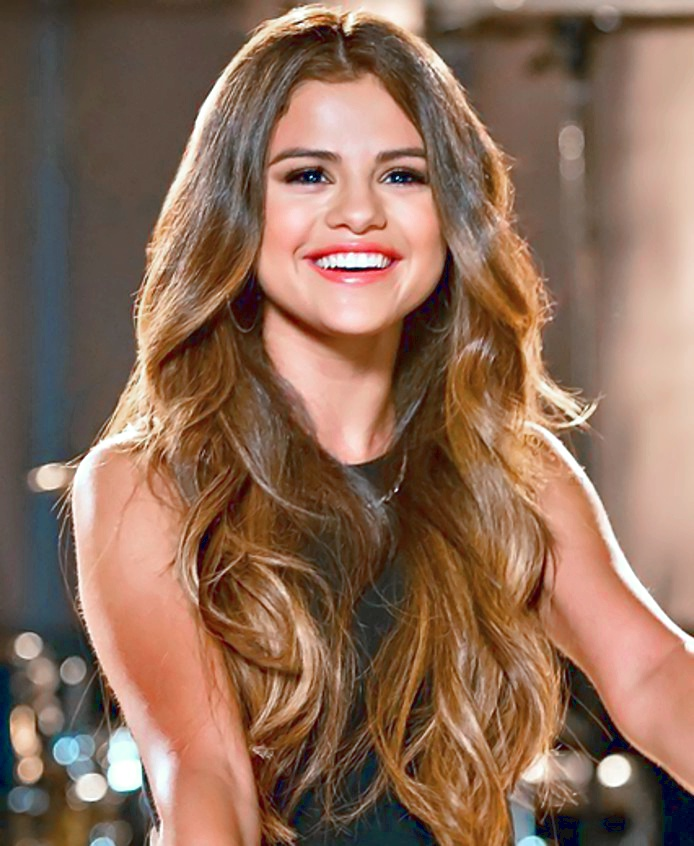

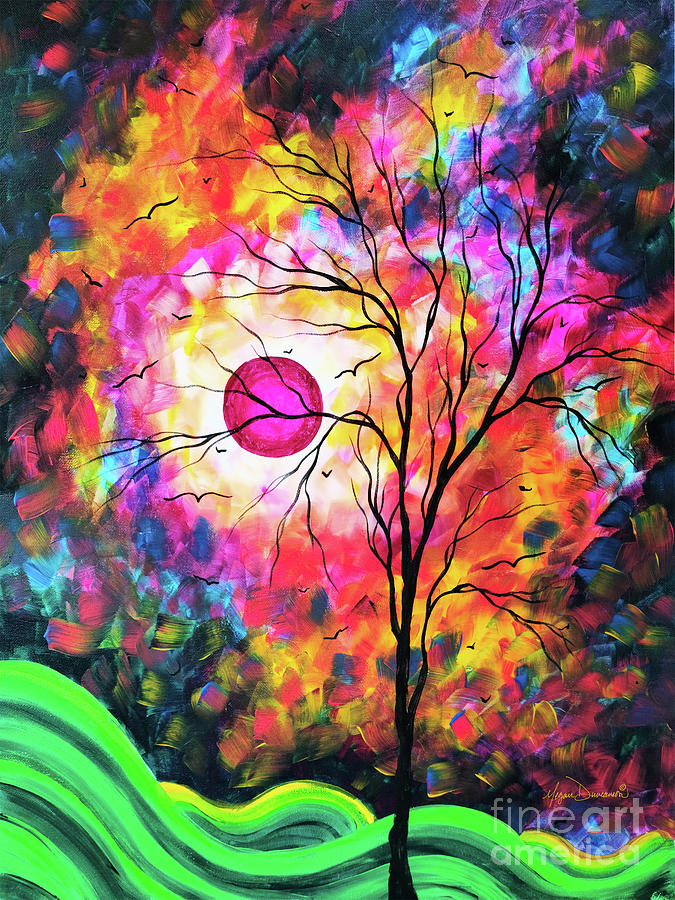

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

## Step 3 - Image preprocessing / deprocessing utilities

The next step after importing the required libraries and image paths is to ensure to define some functions for pre-processing the images accordingly. We will construct two functions. The first function is to pre-process the images and load them accordingly with the help of the VGG-19 transfer learning model. We will convert the images into a tensor format capable of computing the required operations as desired. We will also build a function to recreate the pre-processed image once all the required computations have been performed as desired. 

In [ ]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## Step 4 - Computing the loss

The next step is to create the total loss function, which will be a combination of the content loss and the style loss.

In the below code snippet, we are defining four functions that will be paramount to compute the overall loss. The gram matrix function is used for computing the style loss.

The style loss function keeps the generated image close to the local textures of the style reference image, while the content loss function keeps the high-level representation of the generated image close to that of the base image. The total loss function is used to keep the generated locally coherent, which means we want to keep the loss in a logically consistent way.



In [ ]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

## Step 5 - Develop the Deep CNN network

Once we finish defining our total loss function accordingly, we can proceed to create and develop the entire architecture of the deep convolutional network required for completing the task of neural style transfer. Similar to the architecture discussed in the previous section, we will utilize the VGG-19 architecture, which will contain the five essential convolutional blocks required for this project.

The fully connected layers are ignored and discarded in this transfer learning architecture. We will utilize the deep convolutional network with only convolution layers and pooling layers. Once the features are extracted, the output of this network will be passed with the appropriate loss function, which is a combination of the content and the style loss.

In [ ]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80150528/80134624 [==============================] - 2s 0us/step


In [ ]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

## Step 6 - Create Training Loop

The first step involved in building this section is by creating the decorator training loop. Once we create the decorator function, our task will be to define the optimizer. We will use the stochastic gradient descent optimizer with a learning rate and momentum for this project.

We will then proceed to pre-process and load all the three required images for the training process. Finally, we will begin to train the loop for around 2000 iterations. You can choose to train the following neural style transfer for more epochs and iterations if you want. We will also ensure that once the training process is complete, we will proceed to recreate the generated image using the de-process image function that we have previously defined. 

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [ ]:
ALL_LOSSES = []

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    ALL_LOSSES.append(loss)
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=6261.15
Iteration 200: loss=5603.37
Iteration 300: loss=4156.56
Iteration 400: loss=4250.22
Iteration 500: loss=3856.96
Iteration 600: loss=3500.60
Iteration 700: loss=3333.41
Iteration 800: loss=3268.58
Iteration 900: loss=3074.55
Iteration 1000: loss=3035.82
Iteration 1100: loss=2958.82
Iteration 1200: loss=2887.47
Iteration 1300: loss=2842.32
Iteration 1400: loss=2812.16
Iteration 1500: loss=2766.72
Iteration 1600: loss=2731.22
Iteration 1700: loss=2701.12
Iteration 1800: loss=2674.39
Iteration 1900: loss=2650.52
Iteration 2000: loss=2628.93
Iteration 2100: loss=2609.57
Iteration 2200: loss=2592.19
Iteration 2300: loss=2576.47
Iteration 2400: loss=2562.13
Iteration 2500: loss=2549.01
Iteration 2600: loss=2536.96
Iteration 2700: loss=2525.84
Iteration 2800: loss=2515.56
Iteration 2900: loss=2506.06
Iteration 3000: loss=2497.20
Iteration 3100: loss=2488.95
Iteration 3200: loss=2481.25
Iteration 3300: loss=2474.06
Iteration 3400: loss=2467.33
Iteration 3500: loss=24

## Step 7 – Display final output image

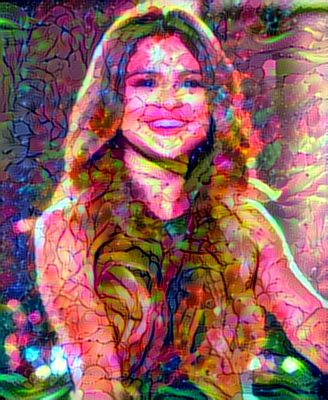

In [ ]:
display(Image(result_prefix + "_at_iteration_4000.png"))

## Step 8 – Display the plot for the losses computed during the generation of final image

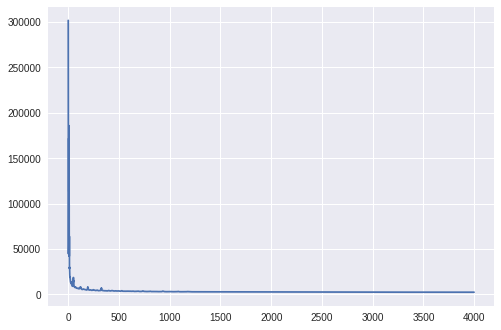

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.plot(ALL_LOSSES)
plt.show()

# Developing Neural Style Transfer with TensorFlow Hub

 TensorFlow Hub consists of a bunch of pre-trained deep learning models for a variety of tasks such as BERT, Faster R-CNN, and so much more that we can reuse over and over again to generate results quickly for particular purposes. For the available models, you can fine-tune them accordingly and deploy them anywhere for performing the specific task.

## Step 1 - Importing the essential libraries

The first step is to import all the essential libraries that we will utilize for the construction of this project. We will load the TensorFlow deep learning framework along with the TensorFlow Hub for accessing the pre-trained neural style transfer model. We will also import the matplotlib library to visualize the output of the generated images. You can also visualize the content or style images accordingly. The numpy library will help us to squeeze the dimensions of the generated images so that the matplotlib library can access the generated picture. Finally, we will import the computer vision cv2 library for exporting and saving the generated image if required.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import cv2

After importing all the required libraries, we can also access the pre-trained neural style transfer model from TensorFlow Hub. The model link variable represents the link to the TensorFlow Hub website that contains the path to the stored and trained neural style transfer model. The NST model variable will load the respective link with which we can access and perform the action of applying the neural style transfer algorithm directly without too many coding requirements. Below is the code snippet for accessing the pre-trained model.

In [ ]:
model_link = "https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"
NST_model = hub.load(model_link)

## Step 2 - Passing and interpreting the data

In the next code snippet, we will create a function to obtain the data, load them, and operate on them accordingly. The following function will read the image path to the saved images in the respective directory. We will then detect and decode the particular image, convert it into our desired data type, and expand the dimension. Finally, the function returns the operated image. We will use the constructed function for loading, accessing, and operating on both the content and style images.

In [ ]:
def get_data(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [ ]:
content_image = get_data('content2.jpg')
style_image = get_data('style3.jpg')

## Step 3 - Obtaining results through the loaded model

Finally, we can proceed to generate the new image that will be performed by the loaded pre-trained neural style transfer model. We need to pass the two primary parameters to the model to evaluate them and generate a resulting image. We will pass the content image (the bridge) as the first parameter and the style image (Van Gogh Starry Night) as the second parameter. We will store the resulting picture in the generated image variable. Below is the code block that will perform the following action.

In [ ]:
generated_image = NST_model(tf.constant(content_image), tf.constant(style_image))[0]

## Step 4 – Display final output image

(-0.5, 695.5, 847.5, -0.5)

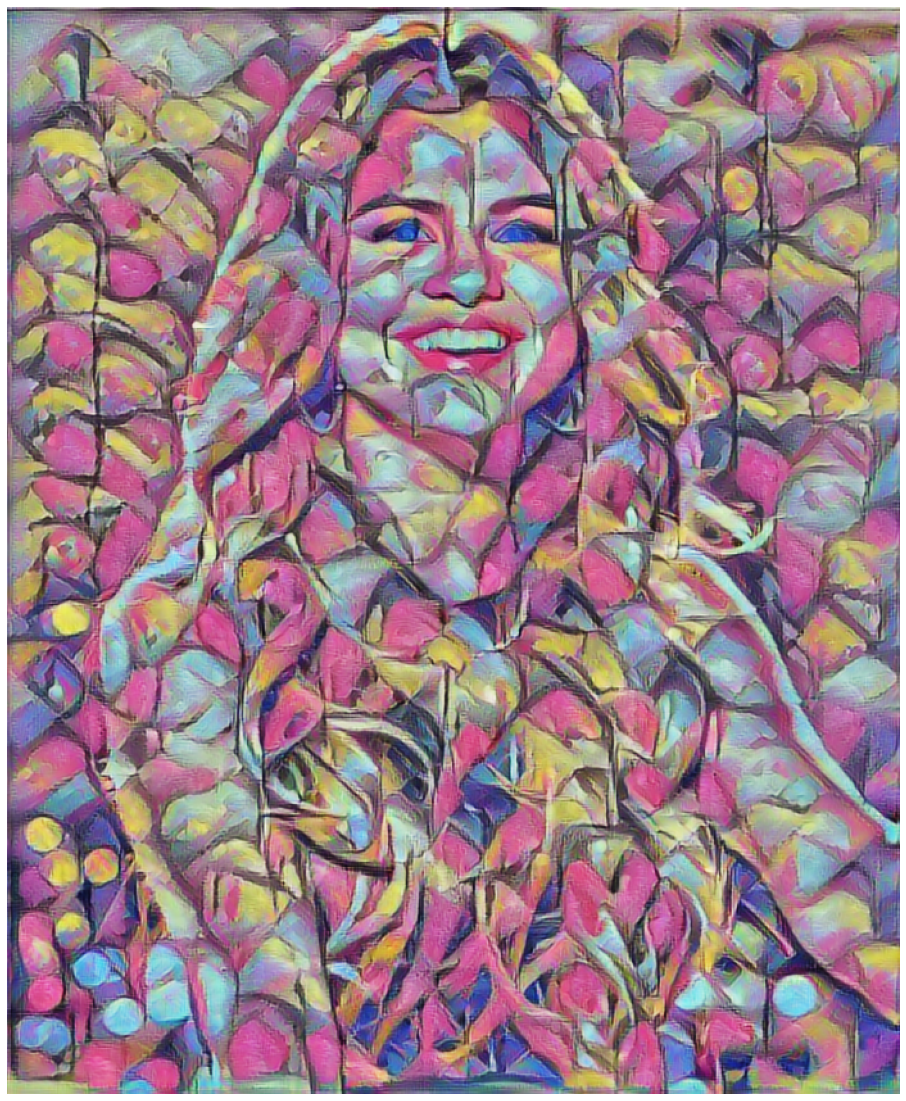

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(np.squeeze(generated_image))
plt.axis("off")